In [59]:
import pandas as pd

df = pd.read_csv("http://www.stat.columbia.edu/~gelman/book/data/football.asc", header=5, delim_whitespace=True)
year = [int(i/224) for i in range(len(df))]
df['year'] = year
df['year'] = df['year'].map({0:1981, 1:1983, 2:1984, 3:1985, 4:1986, 5:1988, 6:1989, 7:1990, 8:1991, 9:1992})

Each season is 224 games and of course they're strung together. Data is from 1981, 1983-1986, 1988-1992

In [68]:
df2 = df.iloc[:672] # first 3 yrs
df2.head()

,home,favorite,underdog,spread,favorite.name,underdog.name,week,year
0,1,21,13,2.0,TB,MIN,1,1981
1,1,27,0,9.5,ATL,NO,1,1981
2,1,31,0,4.0,BUF,NYJ,1,1981
3,1,9,16,4.0,CHI,GB,1,1981
4,1,27,21,4.5,CIN,SEA,1,1981


In [73]:
df2['outcome'] = df2['favorite'] - df2['underdog']

/var/folders/29/f5j1jzy53gb1vyk06d20mz080000gq/T/ipykernel_21514/2317327406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['outcome'] = df2['favorite'] - df2['underdog']


In [74]:
import matplotlib.pyplot as plt

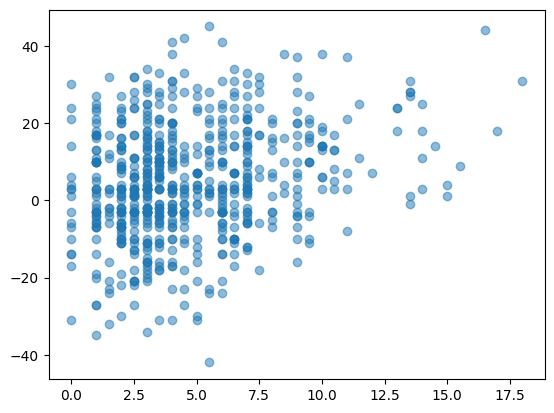

In [83]:
plt.scatter(x=df2['spread'], y=df2['outcome'], alpha=0.5)

In [85]:
df2['outcome - point spread'] = df2['outcome'] - df2['spread']

/var/folders/29/f5j1jzy53gb1vyk06d20mz080000gq/T/ipykernel_21514/3362931288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['outcome - point spread'] = df2['outcome'] - df2['spread']


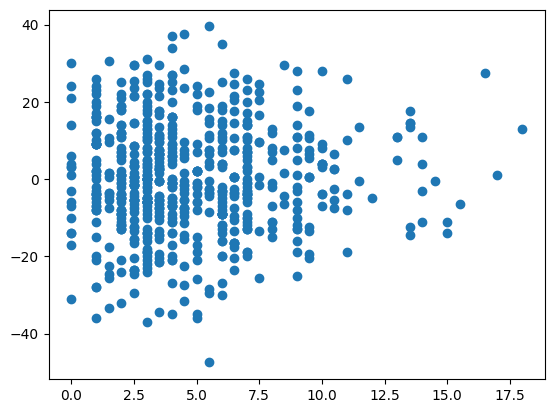

In [87]:
plt.scatter(df2['spread'], df2['outcome - point spread'])

(array([  1.,  10.,  27.,  78., 144., 172., 122.,  74.,  38.,   6.]),
 array([-47.5, -38.8, -30.1, -21.4, -12.7,  -4. ,   4.7,  13.4,  22.1,
         30.8,  39.5]),
 <BarContainer object of 10 artists>)

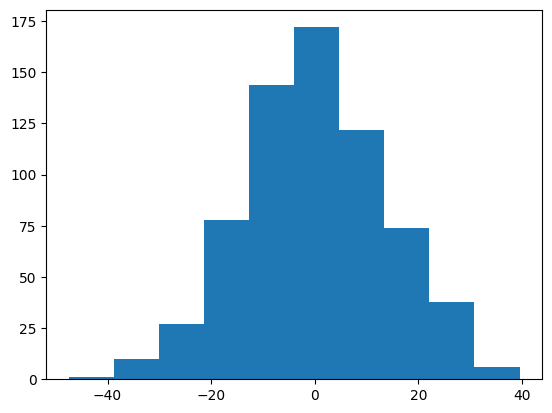

In [88]:
plt.hist(df2['outcome - point spread'])

In [99]:
df2['outcome - point spread'].std()

13.859993612814954

In [128]:
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random

In [120]:
x = jnp.array(df2['spread'])
y = jnp.array(df2['outcome'])
d = jnp.array(df2['outcome - point spread'])

In [117]:
def football(d):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.HalfCauchy(1.0))
    y = numpyro.sample('y', dist.Normal(mu, sigma), obs=d) # prior

In [118]:
rng_key = random.PRNGKey(0)
key1, key2 = random.split(key=rng_key, num=2)
mcmc = MCMC(NUTS(football), num_samples=1000, num_warmup=1000)
mcmc.run(key1, d)


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1931.07it/s, 3 steps of size 8.46e-01. acc. prob=0.92]


In [119]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.05      0.47      0.07     -0.63      0.82    587.67      1.00
     sigma     13.85      0.37     13.83     13.21     14.46   1116.90      1.00

Number of divergences: 0


What is the probability that the favorite wins given x = 3.5?, i.e. $P(y>0|x=3.5)$

In [121]:
posterior_samples = mcmc.get_samples()

In [129]:
# posterior predictive
posterior_predictive = Predictive(football, posterior_samples)

In [139]:
preds = posterior_predictive(key2, y)['y']

In [161]:
dist.Normal(0.05, 13.85).cdf(134)

Array(1., dtype=float32)